In [2]:
import torch
print("GPU Hazır mı?:", torch.cuda.is_available())
print("Kart İsmi:", torch.cuda.get_device_name(0))

GPU Hazır mı?: True
Kart İsmi: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
from datasets import load_dataset

c:\Users\Casper\OneDrive\Desktop\Uygulamalar\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
emotions = load_dataset("dair-ai/emotion")

In [5]:
train_ds = emotions["train"]

In [6]:
train_ds.features

{'text': Value('string'),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}

In [7]:
import pandas as pd

In [8]:
emotions.set_format(type="pandas")

In [9]:
df = emotions["train"][:]

In [10]:
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [11]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [12]:
df["label_name"] = df["label"].apply(label_int2str)

In [13]:
import matplotlib.pyplot as plt

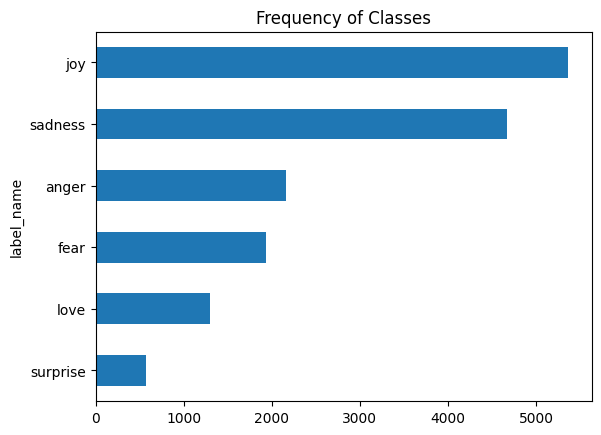

In [14]:
df["label_name"].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Text(0.5, 0, '')

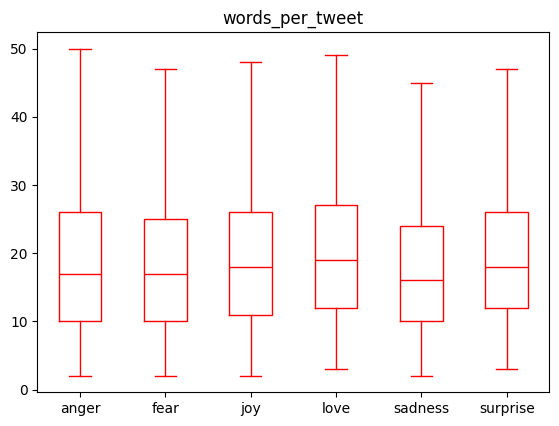

In [15]:
df["words_per_tweet"] = df["text"].str.split().apply(len)
df.boxplot("words_per_tweet" , by = "label_name" , grid = False , showfliers = False , color = "red")
plt.suptitle("")
plt.xlabel("")

In [16]:
emotions.reset_format()

In [17]:
from transformers import AutoTokenizer

In [18]:
model_ckpt = "distilbert-base-uncased"

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

c:\Users\Casper\OneDrive\Desktop\Uygulamalar\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
def tokenize(batch):
    return tokenizer(batch["text"] , truncation=True)

In [21]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [22]:
emotions_encoded = emotions.map(tokenize , batched = True , batch_size = None)

In [23]:
from transformers import DataCollatorWithPadding

In [24]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [25]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [26]:
from transformers import AutoModelForSequenceClassification

In [27]:
num_labels = 6

In [28]:
import torch

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt , num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
import evaluate

In [32]:
accuracy = evaluate.load("accuracy")

In [33]:
import numpy as np

In [34]:
def compute_metrics(eval_pred):
    predictions , labels = eval_pred
    predictions = np.argmax(predictions , axis = 1)
    return accuracy.compute(predictions=predictions,
                            references = labels)

In [35]:
from transformers import TrainingArguments

In [36]:
training_args = TrainingArguments(
    output_dir="distilbert-emotions",
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
)

In [37]:
from transformers import Trainer

In [38]:
trainer = Trainer(
    model = model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset = emotions_encoded["train"],
    eval_dataset = emotions_encoded["validation"],
    data_collator=data_collator,
)

In [39]:
trainer.train()

                                                 
 33%|███▎      | 250/750 [00:46<01:34,  5.27it/s]

{'eval_loss': 0.17896653711795807, 'eval_accuracy': 0.934, 'eval_runtime': 1.7641, 'eval_samples_per_second': 1133.719, 'eval_steps_per_second': 18.14, 'epoch': 1.0}


 67%|██████▋   | 500/750 [01:32<00:45,  5.51it/s]

{'loss': 0.3206, 'grad_norm': 7.136202812194824, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 500/750 [01:34<00:45,  5.51it/s]

{'eval_loss': 0.13656094670295715, 'eval_accuracy': 0.9415, 'eval_runtime': 1.7675, 'eval_samples_per_second': 1131.518, 'eval_steps_per_second': 18.104, 'epoch': 2.0}


                                                 
100%|██████████| 750/750 [02:23<00:00,  5.77it/s]

{'eval_loss': 0.12291406095027924, 'eval_accuracy': 0.944, 'eval_runtime': 1.7979, 'eval_samples_per_second': 1112.403, 'eval_steps_per_second': 17.798, 'epoch': 3.0}


100%|██████████| 750/750 [02:24<00:00,  5.18it/s]

{'train_runtime': 144.6759, 'train_samples_per_second': 331.776, 'train_steps_per_second': 5.184, 'train_loss': 0.24457313791910806, 'epoch': 3.0}


TrainOutput(global_step=750, training_loss=0.24457313791910806, metrics={'train_runtime': 144.6759, 'train_samples_per_second': 331.776, 'train_steps_per_second': 5.184, 'total_flos': 702326010350592.0, 'train_loss': 0.24457313791910806, 'epoch': 3.0})

In [40]:
preds_output = trainer.predict(emotions_encoded["validation"])

100%|██████████| 32/32 [00:01<00:00, 18.90it/s]


In [42]:
preds_output.metrics

{'test_loss': 0.12291406095027924,
 'test_accuracy': 0.944,
 'test_runtime': 2.0179,
 'test_samples_per_second': 991.151,
 'test_steps_per_second': 15.858}

In [43]:
y_preds = np.argmax(preds_output.predictions , axis = 1)

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay , confusion_matrix

In [45]:
def plot_confusion_matrix(y_preds , y_true , labels):
   cm = confusion_matrix(y_true , y_preds , normalize="true")
   fig , ax = plt.subplots(figsize=(6,6))
   disp =  ConfusionMatrixDisplay(confusion_matrix = cm ,
                                  display_labels=labels)
   disp.plot(cmap="Blues" , values_format=".2f" , ax=ax,
             colorbar=False)
   plt.title("Normalize Confusion Matrix")
   plt.show()

In [46]:
y_valid = np.array(emotions_encoded["validation"]["label"])

In [47]:
labels = emotions["train"].features["label"].names

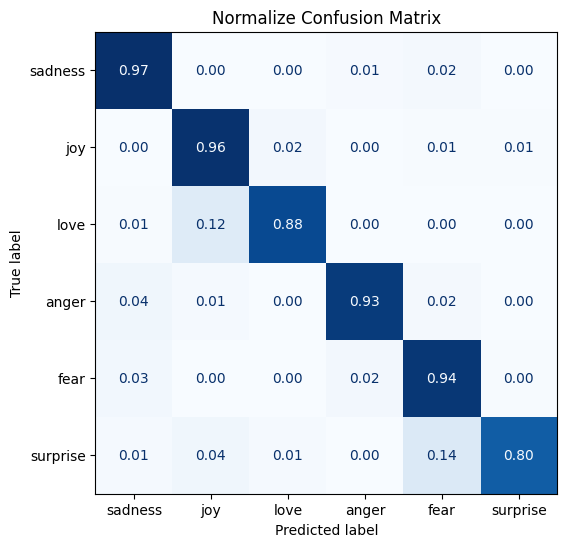

In [48]:
plot_confusion_matrix(y_preds , y_valid , labels)

In [52]:
duygular = ["sadness","joy","love","anger","fear","surprise"]
tahmin = model(**tokenizer("giganotosaurus u seviyorum çok güçlü ancak çok aptal",return_tensors="pt").to("cuda"))
print(duygular[tahmin.logits.argmax()])

fear
